In [1]:
import sys
sys.path.append("..")

from ris_evaluation.evaluator import Evaluator

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora, models
import gensim

In [2]:
class LDABaseModel:

    def __init__(self, documents_df: pd.DataFrame):
        self.documents_df = documents_df

        self.documents = documents_df['document'].tolist()
        self.labels = documents_df['class_name'].tolist()

        labels_df = pd.read_csv('../../datasets/data/BBC_News/labels.csv')
        self.defined_keywords = [keywords.split(' ') for keywords in labels_df['class_keywords'].tolist()]

        self.model = None

    def get_words_for_topics(self, topics: list):
        """ Get the words for each topic from the documents

        Args:
            topics (list): The topics for each document

        Returns:
            dict: The words for each topic
        """
        words_by_topics = {}
        for idx, topic in enumerate(topics):
            words = self.documents_df.iloc[idx]['document'].split()

            if topic not in words_by_topics:
                words_by_topics[topic] = {}

            for word in words:
                if word not in words_by_topics[topic]:
                    words_by_topics[topic][word] = 0

                words_by_topics[topic][word] += 1

        return words_by_topics
    
    def get_results_df(self):
        raise NotImplementedError
    
    def compute_supervised_correlation(self, results_df: pd.DataFrame):
        raise NotImplementedError
    
    def get_most_important_words_by_topic(self, n_words: int = 5):
        raise NotImplementedError

In [3]:
class GuidedLDA(LDABaseModel):

    def __init__(self, documents_df) -> None:
        super().__init__(documents_df)

    def train(self):
        n_topics = len(self.defined_keywords)

        # Convert the seed words to the corresponding word indices
        self.texts = [document.split(' ') for document in self.documents]
        
        self.dictionary = corpora.Dictionary(self.texts)
        self.corpus = [self.dictionary.doc2bow(text) for text in self.texts]
        
        # word2id = {v: k for k, v in self.dictionary.token2id.items()}
        # seed_topic_vecs = []
        # for seed in self.defined_keywords:
        #     vec = [0] * len(self.dictionary)
        #     for word in seed:
        #         if word in word2id:
        #             vec[word2id[word]] = 1
        #     seed_topic_vecs.append(vec)

        # # Run the LDA model with guidance
        # self.model = gensim.models.LdaModel(self.corpus, num_topics=n_topics, random_state=0, id2word=self.dictionary)
        # for i, seed_vec in enumerate(seed_topic_vecs):
        #     seed_vec = np.array(seed_vec) + 1e-8  # Adding a small constant to avoid zero values
        #     self.model.expElogbeta[i] = np.log(seed_vec)

        priors = {}
        for idx, keywords in enumerate(self.defined_keywords):
            for keyword in keywords:
                priors[keyword] = idx

        eta = np.full(shape=(n_topics, len(self.dictionary)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
        for word, topic in priors.items(): # for each word in the list of priors
            keyindex = [index for index,term in self.dictionary.items() if term == word] # look up the word in the dictionary
            if (len(keyindex) > 0): # if it's in the dictionary
                eta[topic,keyindex[0]] = 1e7  # put a large number in there
        eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics

        with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
            self.model = gensim.models.ldamodel.LdaModel(
                corpus=self.corpus, id2word=self.dictionary, num_topics=n_topics,
                random_state=42, chunksize=100, eta=eta,
                eval_every=-1, update_every=1,
                passes=150, alpha='auto', per_word_topics=True)

    def get_results_df(self):
        self.results_df = pd.DataFrame()
        self.results_df['document'] = self.documents
        self.results_df['y_true'] = self.documents_df['class_name'].tolist()

        scores = [[value[1] for value in score_values[0]] for score_values in self.model[self.corpus]]
        self.results_df['y_pred'] = [np.argmax(score) for score in scores]
        self.results_df['y_pred_highest_proba'] = [np.max(score) for score in scores]
        return self.results_df
    
    def compute_supervised_correlation(self, results_df: pd.DataFrame):
        model_output = {}
        evaluator = Evaluator(model_output)

        words_by_extracted_topics = self.get_words_for_topics(results_df['y_pred'].tolist())
        words_by_class = self.get_words_for_topics(results_df['y_true'].tolist())

        return evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)
    
    def get_most_important_words_by_topic(self, n_words: int = 5):
        topics = self.model.show_topics(num_topics=len(self.defined_keywords), num_words=n_words, formatted=False)
        # id2word = {v: k for k, v in self.dictionary.token2id.items()}

        most_important_words_by_topic = {}
        for topic in topics:
            most_important_words_by_topic[topic[0]] = [word[0] for word in topic[1]]

        # Count the number of occurences of each word in each topic
        most_important_words_by_topic_with_occurences = {}
        for topic in most_important_words_by_topic:
            most_important_words_by_topic_with_occurences[topic] = []
            for word in most_important_words_by_topic[topic]:
                topic_df = self.results_df[self.results_df['y_pred'] == topic]
                occurences = topic_df['document'].str.contains(word).sum()
                most_important_words_by_topic_with_occurences[topic].append((word, occurences))

        return most_important_words_by_topic_with_occurences

In [4]:
class BasicLDA(LDABaseModel):

    def __init__(self, documents_df: pd.DataFrame):
        super().__init__(documents_df)

    def train(self):
        self.vectorizer = CountVectorizer()
        self.X = self.vectorizer.fit_transform(self.documents)

        self.lda = LatentDirichletAllocation(n_components=len(set(self.labels)), random_state=0)
        self.lda.fit(self.X)

    def get_results_df(self):
        self.results_df = pd.DataFrame()
        self.results_df['document'] = self.documents
        self.results_df['y_true'] = self.documents_df['class_name'].tolist()
        self.results_df['y_pred'] = self.lda.transform(self.X).argmax(axis=1)
        self.results_df['y_pred_highest_proba'] = self.lda.transform(self.X).max(axis=1)
        return self.results_df
    
    def compute_supervised_correlation(self, results_df: pd.DataFrame):
        topics = []
        for topic in self.lda.components_:
            topic_words = []
            for i in topic.argsort()[-10:]:
                topic_words.append(self.vectorizer.get_feature_names_out()[i])
            topics.append(topic_words)

        model_output = {}
        evaluator = Evaluator(model_output)

        words_by_extracted_topics = self.get_words_for_topics(results_df['y_pred'].tolist())
        words_by_class = self.get_words_for_topics(results_df['y_true'].tolist())

        return evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)
    
    def get_most_important_words_by_topic(self, n_words: int = 5):
        topics = []
        for topic in self.lda.components_:
            topic_words = []
            for i in topic.argsort()[-n_words:]:
                topic_words.append(self.vectorizer.get_feature_names_out()[i])
            topics.append(topic_words)

        most_important_words_by_topic = {}
        for idx, topic in enumerate(topics):
            most_important_words_by_topic[idx] = topic

        # Count the number of occurences of each word in each topic
        most_important_words_by_topic_with_occurences = {}
        for topic in most_important_words_by_topic:
            most_important_words_by_topic_with_occurences[topic] = []
            for word in most_important_words_by_topic[topic]:
                topic_df = self.results_df[self.results_df['y_pred'] == topic]
                most_important_words_by_topic_with_occurences[topic].append((word, topic_df['document'].str.contains(word).sum()))

        return most_important_words_by_topic_with_occurences

In [5]:
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')

In [6]:
# -- Normal version
basic_lda = BasicLDA(documents_df)
basic_lda.train()

# -- Guided version
guided_lda = GuidedLDA(documents_df)
guided_lda.train()

In [7]:
basic_results_df = basic_lda.get_results_df()
guided_results_df = guided_lda.get_results_df()

In [8]:
basic_supervised_correlation = basic_lda.compute_supervised_correlation(basic_results_df)
guided_supervised_correlation = guided_lda.compute_supervised_correlation(guided_results_df)

In [9]:
basic_most_important_words = basic_lda.get_most_important_words_by_topic(n_words=10)
guided_most_important_words = guided_lda.get_most_important_words_by_topic(n_words=10)

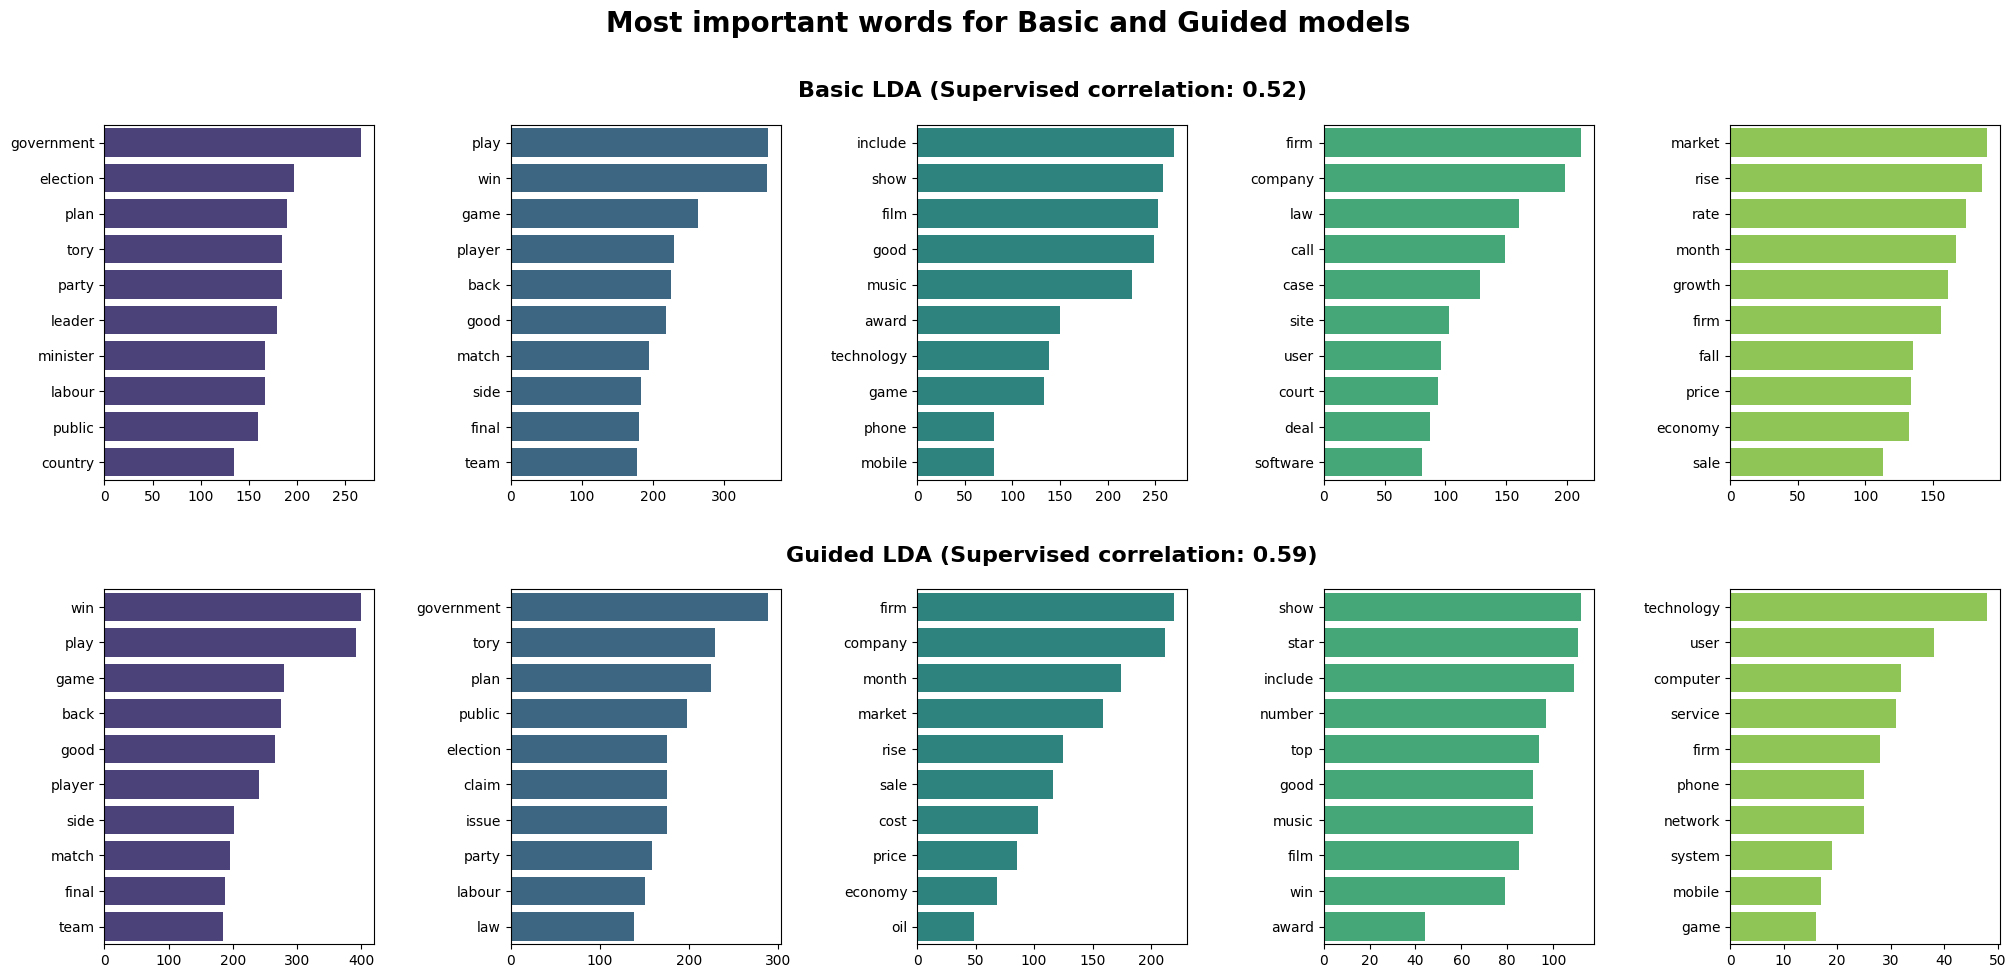

In [10]:
fig, ax = plt.subplots(2, len(basic_most_important_words), figsize=(20, 10))
fig.suptitle('Most important words for Basic and Guided models', fontsize=20, fontweight='bold')

colors = sns.color_palette('viridis', len(basic_most_important_words))

for x, dictionary in enumerate([basic_most_important_words, guided_most_important_words]):
    title = 'Basic LDA' if x == 0 else 'Guided LDA'
    title += f' (Supervised correlation: {round(basic_supervised_correlation, 2)})' if x == 0 else f' (Supervised correlation: {round(guided_supervised_correlation, 2)})'

    ax[x, 2].set_title(title, fontsize=16, fontweight='bold', pad=20)

    for y in range(len(dictionary)):
        words = dictionary[y]
        
        sorted_words = sorted(words, key=lambda x: x[1], reverse=True)
        features = [word[0] for word in sorted_words]
        features_values = [word[1] for word in sorted_words]

        sns.barplot(x=features_values, y=features, ax=ax[x, y], color=colors[y], orient='h')

fig.tight_layout(pad=3.0, rect=[-0.02, -0.02, 1.02, 1.02])
fig.savefig(f'../../figures/guided_lda/most_important_words.png')